# Data Analysis of Network Traffic

## Imports and Dependencies

In [1]:
!pip install xgboost

In [2]:
from datetime import datetime
import numpy as np
import pandas as pd
import statistics
import csv
 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from  sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split,KFold
import xgboost as xgb

## Overview of the data

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
df= pd.read_csv("dataset.csv")
df.drop(['Unnamed: 0'], inplace=True, axis=1)

In [4]:
print("dataset has the shape : {} ".format(df.shape))
print("{} rows and {} columns  \n\n".format(df.shape[0], df.shape[1]))

dataset has the shape : (4968, 15) 
4968 rows and 15 columns  




In [5]:
df.head()

,frame_time_epoch,frame_len,eth_src,device_name_src,eth_dst,device_name_dst,eth_type,ip_src,srcport,ip_dst,dstport,ip_proto,payload_utf8,action,attack
0,1.674747e+09,66,04:CF:4B:3B:00:58,NaN,0E:F2:26:7D:04:1A,NaN,0x0800,18.196.142.136,8883.0,192.168.12.148,38462.0,6.0,NaN,NaN,NaN
1,1.674747e+09,303,A8:03:2A:B1:35:60,NaN,04:CF:4B:3B:00:58,NaN,0x0800,192.168.12.80,51705.0,34.140.193.14,6022.0,6.0,,NaN,NaN
2,1.674747e+09,66,0E:F2:26:7D:04:1A,NaN,04:CF:4B:3B:00:58,NaN,0x0800,192.168.12.148,38462.0,18.196.142.136,8883.0,6.0,NaN,NaN,NaN
3,1.674747e+09,54,04:CF:4B:3B:00:58,NaN,A8:03:2A:B1:35:60,NaN,0x0800,34.140.193.14,6022.0,192.168.12.80,51705.0,6.0,NaN,NaN,NaN
4,1.674747e+09,128,0E:F2:26:7D:04:1A,NaN,FF:FF:FF:FF:FF:FF,NaN,0x0800,192.168.12.148,52149.0,255.255.255.255,7000.0,17.0,NaN,NaN,NaN


In [6]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df_num = df.select_dtypes(include=numerics)
df_cat = df.select_dtypes(include="object")
print("The dataset has {} numerical features and {} Categorigcal features ".format(len(df_num.columns), len(df_cat.columns)))


The dataset has 5 numerical features and 10 Categorigcal features 


In [7]:
df_num.columns

Index(['frame_time_epoch', 'frame_len', 'srcport', 'dstport', 'ip_proto'], dtype='object')

In [8]:
df_cat.columns

Index(['eth_src', 'device_name_src', 'eth_dst', 'device_name_dst', 'eth_type', 'ip_src', 'ip_dst', 'payload_utf8', 'action', 'attack'], dtype='object')

## Missing data

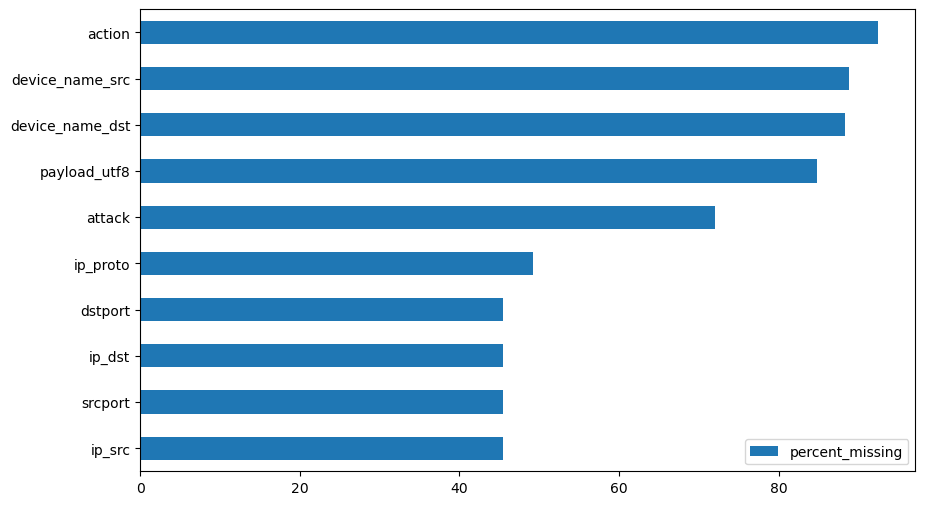

In [9]:
(df.isnull().sum() * 100 / len(df)) \
    .to_frame(name='percent_missing') \
    .query('percent_missing>0') \
    .sort_values(by='percent_missing', ascending=True) \
    .plot.barh( figsize=(10,6));

<AxesSubplot: title={'center': 'Percent for each attack type'}>

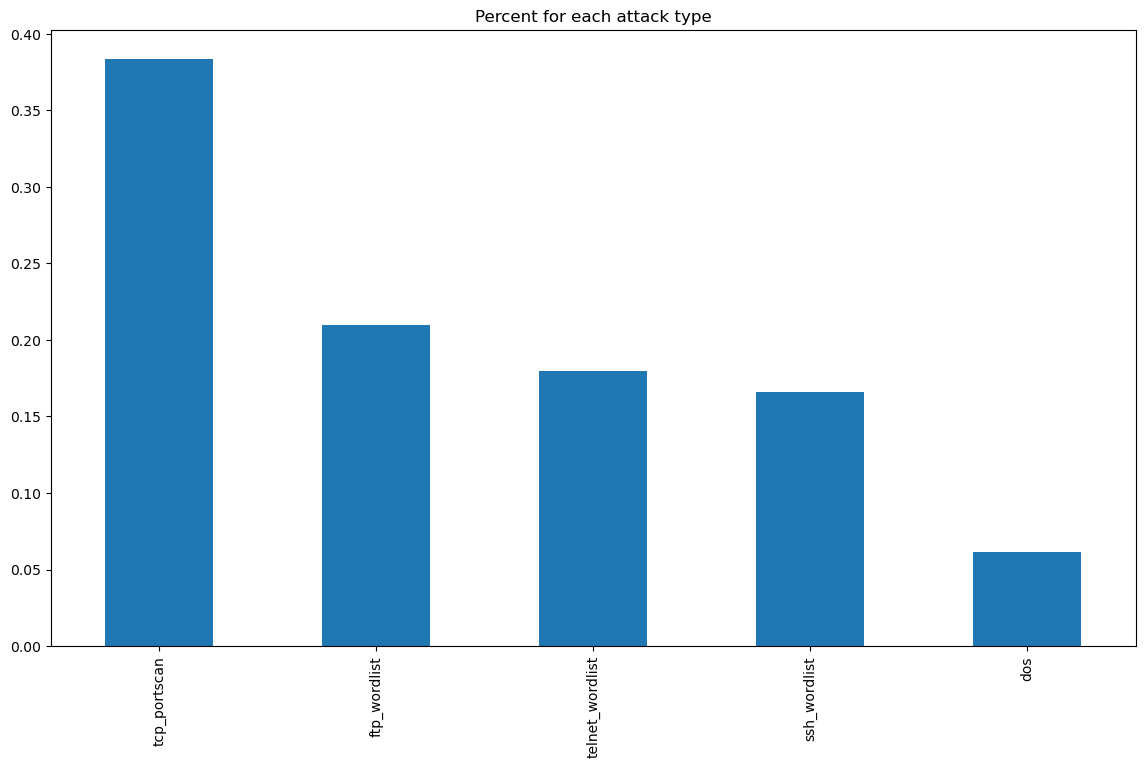

In [10]:
df.attack.value_counts(normalize=True).plot(kind='bar' , figsize=(14,8), title="Percent for each attack type")

## Binary classification

In [11]:
# Remove unnecessary columns
columns_to_remove = [
    'frame_time_epoch','eth_src','device_name_src','eth_dst','device_name_dst','ip_src',
    'ip_dst','payload_utf8','action'
]

df.drop(columns_to_remove, axis=1, inplace=True)

In [12]:
df.head()

,frame_len,eth_type,srcport,dstport,ip_proto,attack
0,66,0x0800,8883.0,38462.0,6.0,NaN
1,303,0x0800,51705.0,6022.0,6.0,NaN
2,66,0x0800,38462.0,8883.0,6.0,NaN
3,54,0x0800,6022.0,51705.0,6.0,NaN
4,128,0x0800,52149.0,7000.0,17.0,NaN


In [13]:
# Convert the attack column into binary column 
df['attack'] = df['attack'].fillna(0)
df['attack'] = np.where(df['attack'] != 0, 1, df['attack'])
df['attack'] = df['attack'].astype(int)

<AxesSubplot: title={'center': 'Percent for each attack type'}>

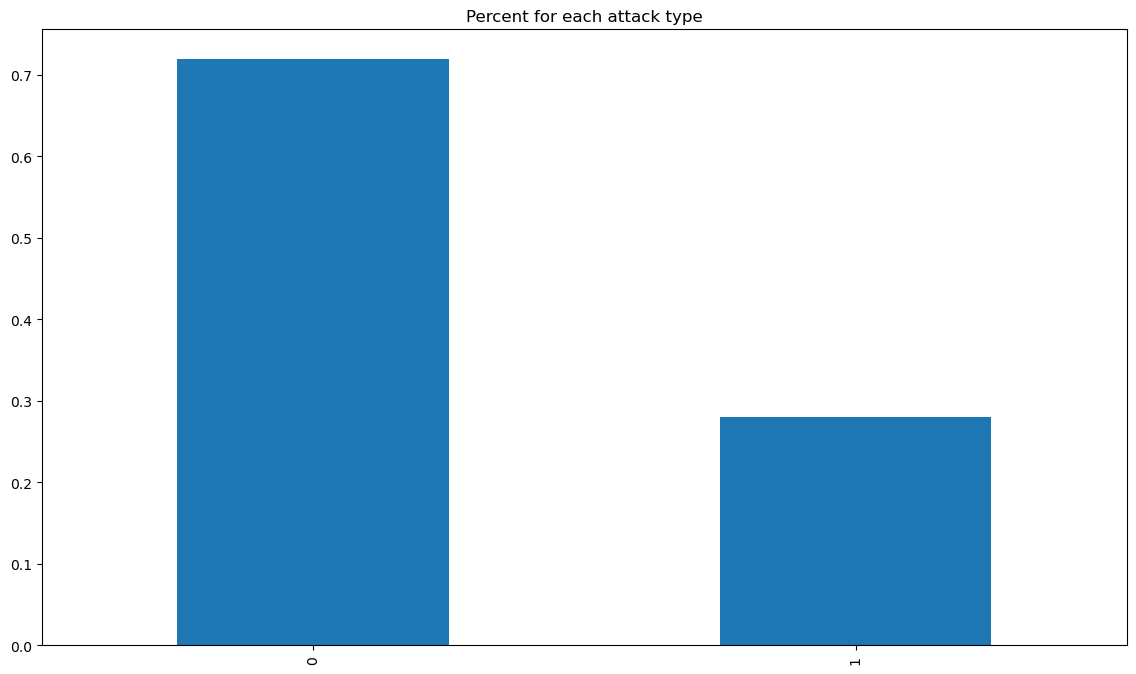

In [14]:
df.attack.value_counts(normalize=True).plot(kind='bar' , figsize=(14,8),
                                    title="Percent for each attack type")

In [15]:
df.attack.value_counts()

0    3575
1    1393
Name: attack, dtype: int64

In [16]:
df.shape

(4968, 6)

In [17]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df_num = df.select_dtypes(include=numerics)
df_cat = df.select_dtypes(include="object")
print("The dataset has {} numerical features and {} Categorigcal features ".format( len(df_num.columns), len(df_cat.columns)  ) )


The dataset has 5 numerical features and 1 Categorigcal features 


In [18]:
df_num.columns

Index(['frame_len', 'srcport', 'dstport', 'ip_proto', 'attack'], dtype='object')

In [19]:
df_cat.columns

Index(['eth_type'], dtype='object')

In [20]:
df["eth_type"].unique()

array(['0x0800', '0x0806'], dtype=object)

In [21]:
# Get one hot encoding of columns eth_type
one_hot = pd.get_dummies(df['eth_type'])
# Drop column eth_type as it is now encoded
df = df.drop('eth_type',axis = 1)
# Join the encoded df
df = df.join(one_hot)
df.head()

,frame_len,srcport,dstport,ip_proto,attack,0x0800,0x0806
0,66,8883.0,38462.0,6.0,0,1,0
1,303,51705.0,6022.0,6.0,0,1,0
2,66,38462.0,8883.0,6.0,0,1,0
3,54,6022.0,51705.0,6.0,0,1,0
4,128,52149.0,7000.0,17.0,0,1,0


In [22]:
df['ip_proto'].unique()

array([ 6., 17., nan])

In [23]:
X = df[['frame_len','srcport','dstport','ip_proto','0x0806']]
Y = df[['attack']]

In [24]:
Y.head()

,attack
0,0
1,0
2,0
3,0
4,0


In [25]:
# XGBoost (different learning rate)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=65)
learning_rate_range = np.arange(0.01, 1, 0.05)
test_XG = [] 
train_XG = []
lernrate = []
for lr in learning_rate_range:
    xgb_classifier = xgb.XGBClassifier(eta = lr)
    xgb_classifier.fit(x_train, y_train)
    lernrate.append(lr)
    train_XG.append(xgb_classifier.score(x_train, y_train))
    test_XG.append(xgb_classifier.score(x_test, y_test)) 

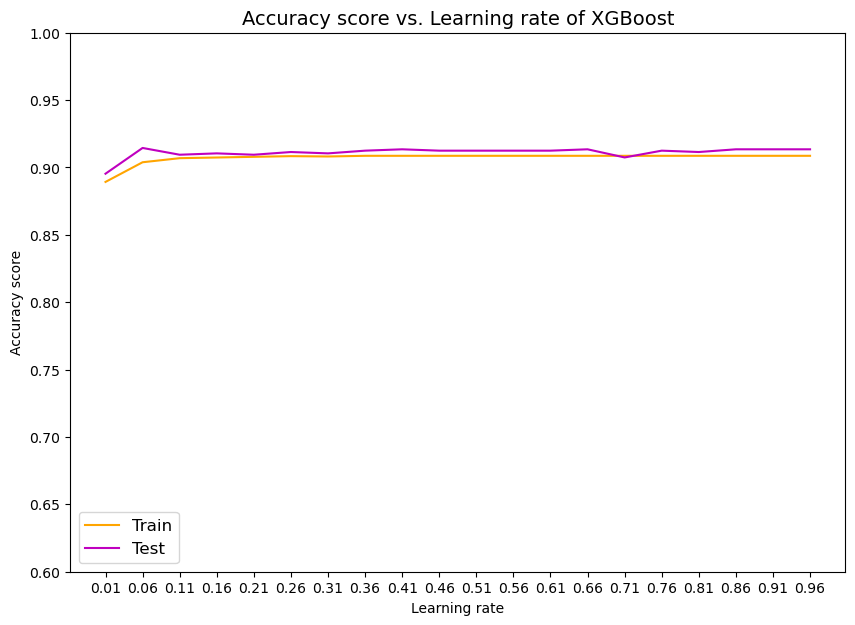

In [26]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax.plot(learning_rate_range, train_XG, c='orange', label='Train')
ax.plot(learning_rate_range, test_XG, c='m', label='Test')
ax.set_xlabel('Learning rate')
ax.set_xticks(learning_rate_range)
ax.set_ylabel('Accuracy score')
ax.set_ylim(0.6, 1)
ax.legend(prop={'size': 12}, loc=3)
ax.set_title('Accuracy score vs. Learning rate of XGBoost', size=14)
plt.show()

### Cross Validation

In [27]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# Define the XGBoost model
model = xgb.XGBClassifier()

# Define the cross-validation scheme
kfold = KFold(n_splits=10)

# Train the model using cross-validation
results = []
for train_index, test_index in kfold.split(X_train):
    model.fit(X_train.iloc[train_index], y_train.iloc[train_index])
    y_pred = model.predict(X_train.iloc[test_index])
    accuracy = accuracy_score(y_train.iloc[test_index], y_pred)
    results.append(accuracy)

mean_accuracy = statistics.mean(results)
print("Mean accuracy: %.2f%% (%.2f%%)" % (mean_accuracy * 100, statistics.stdev(results) * 100))


# Train the model on the full training data
model.fit(X_train, y_train)


importance = model.get_booster().get_score(importance_type="weight")
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
features = [item[0] for item in importance]
print(importance)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Print the accuracy of the model on the test data
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: %.2f%%" % (accuracy * 100.0))

Mean accuracy: 90.46% (1.26%)
[('frame_len', 520.0), ('srcport', 382.0), ('dstport', 352.0), ('ip_proto', 22.0)]
Test Accuracy: 90.95%


### Model Interpretability

To better understand how the model makes predictions and which features have actual predictive power, we took a closer look at the correlation between predictors and response variable.

#### Feature Importance Plot

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

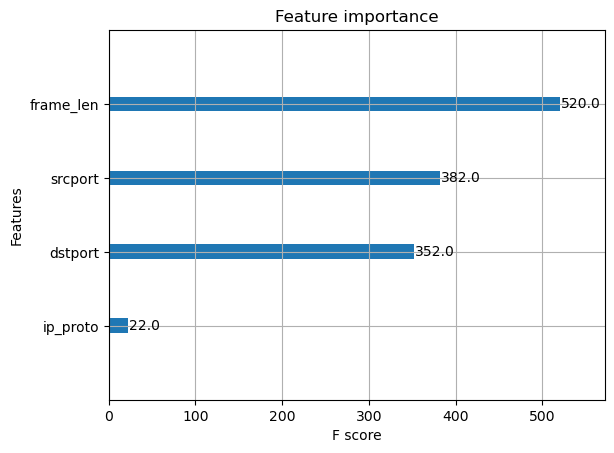

In [28]:
xgb.plot_importance(model)

`frame_len` and port numbers are main drivers for prediction. Let's take a closer look.

#### Correlation between `frame_len` and `attack`

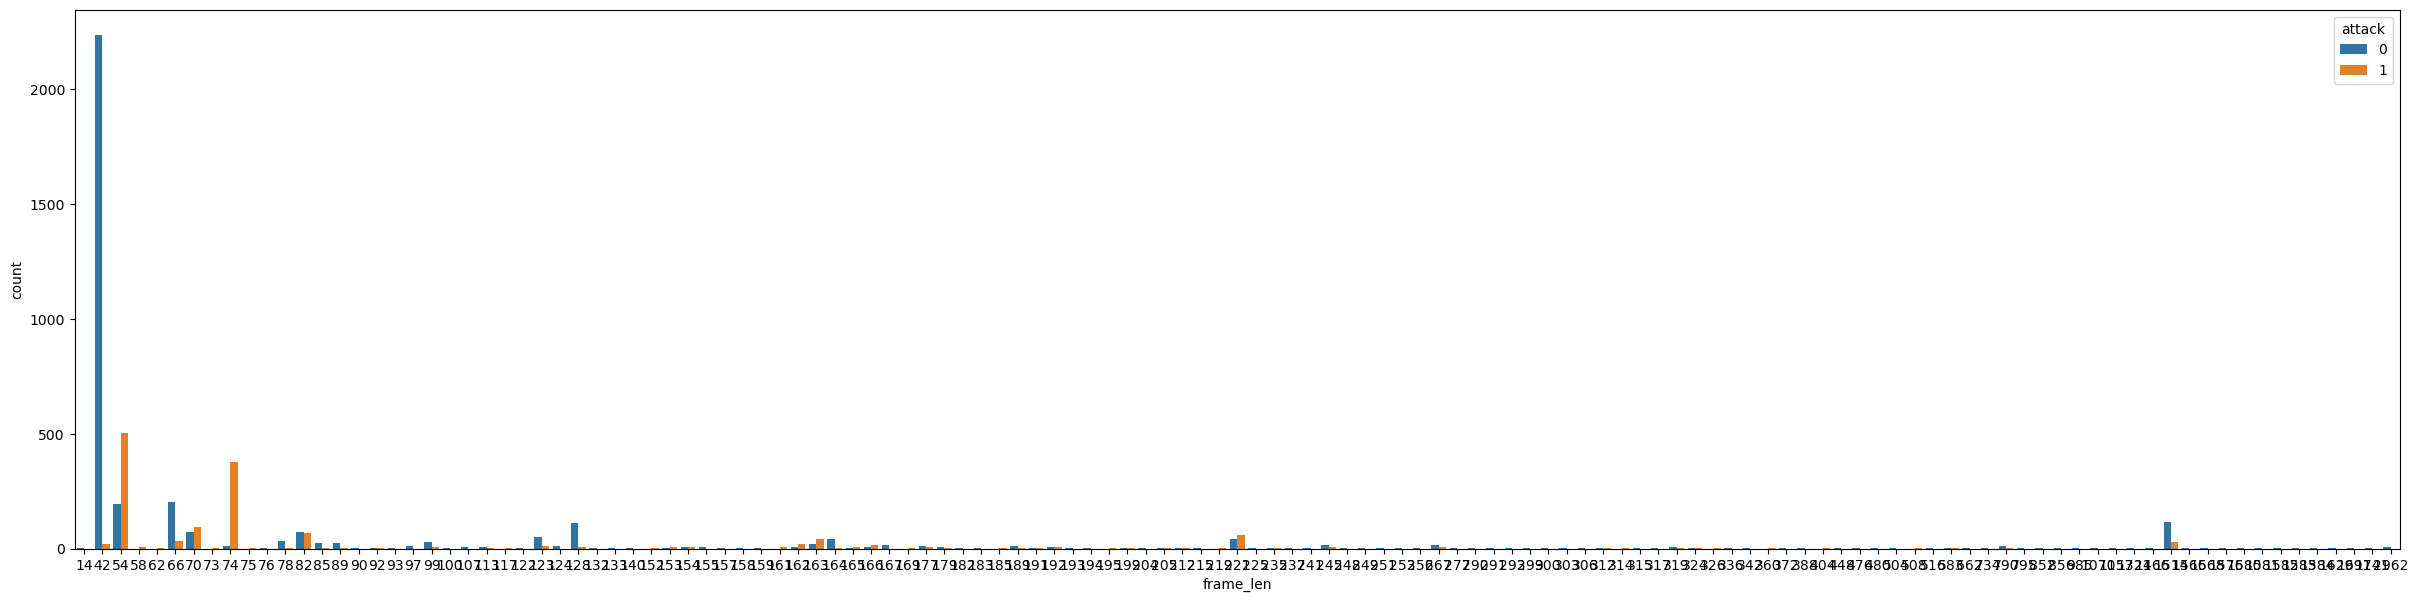

In [29]:
plt.figure(figsize=(30, 7))
sns.countplot(x='frame_len', hue='attack', data=df)
plt.show()

Approximately 900 of 1393 attacks have a frame length of either 54 or 74. Over 2500 legitimate data packets have a frame length of 42. Therefore, `frame_len` is a promising feature for prediction. 

#### Correlation between `srcport` and `attack`

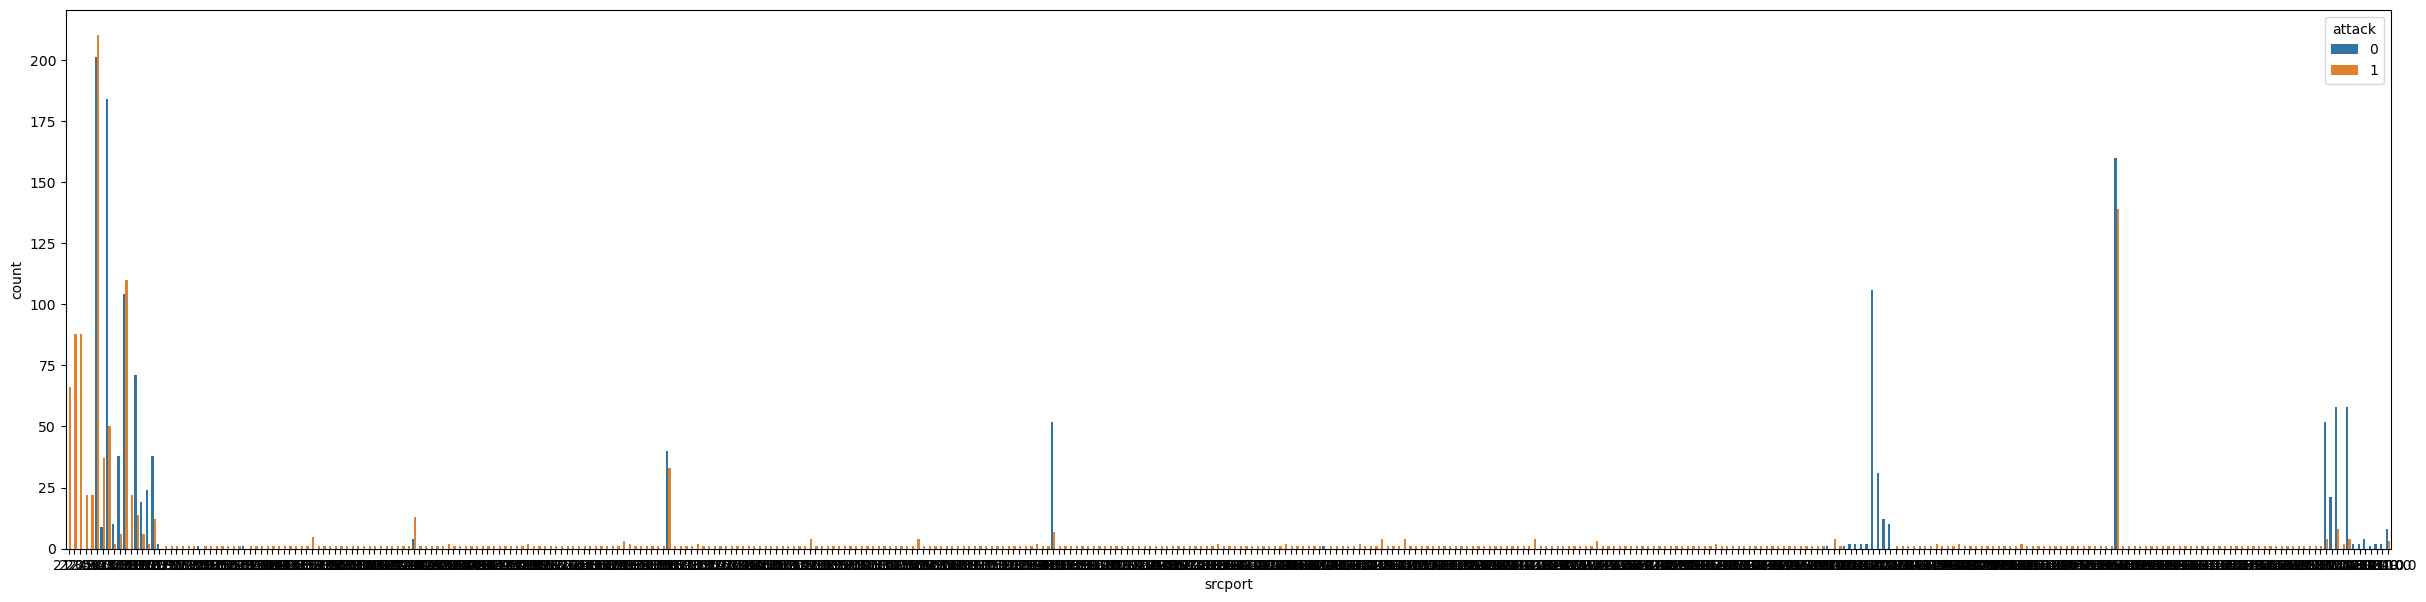

In [30]:
plt.figure(figsize=(30, 7))
sns.countplot(x='srcport', hue='attack', data=df)
plt.show()

The source port numbers are also crucial for classification: malicious requests are often sent from lower port numbers.

#### Correlation between `eth_type` and `attack`

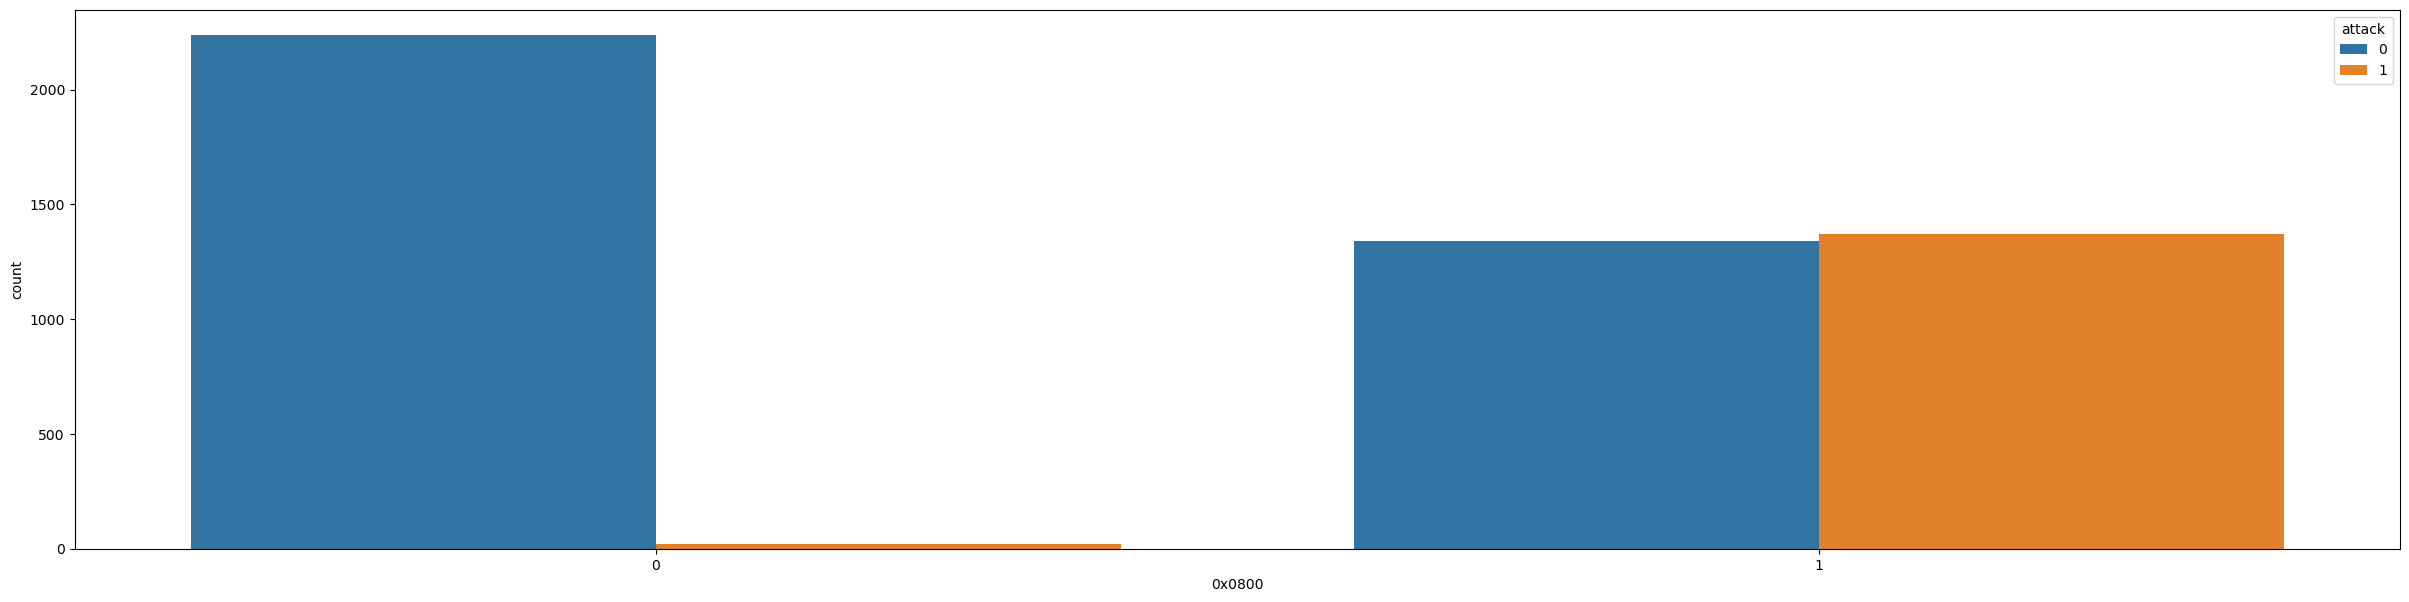

In [31]:
plt.figure(figsize=(30, 7))
sns.countplot(x='0x0800', hue='attack', data=df)
plt.show()

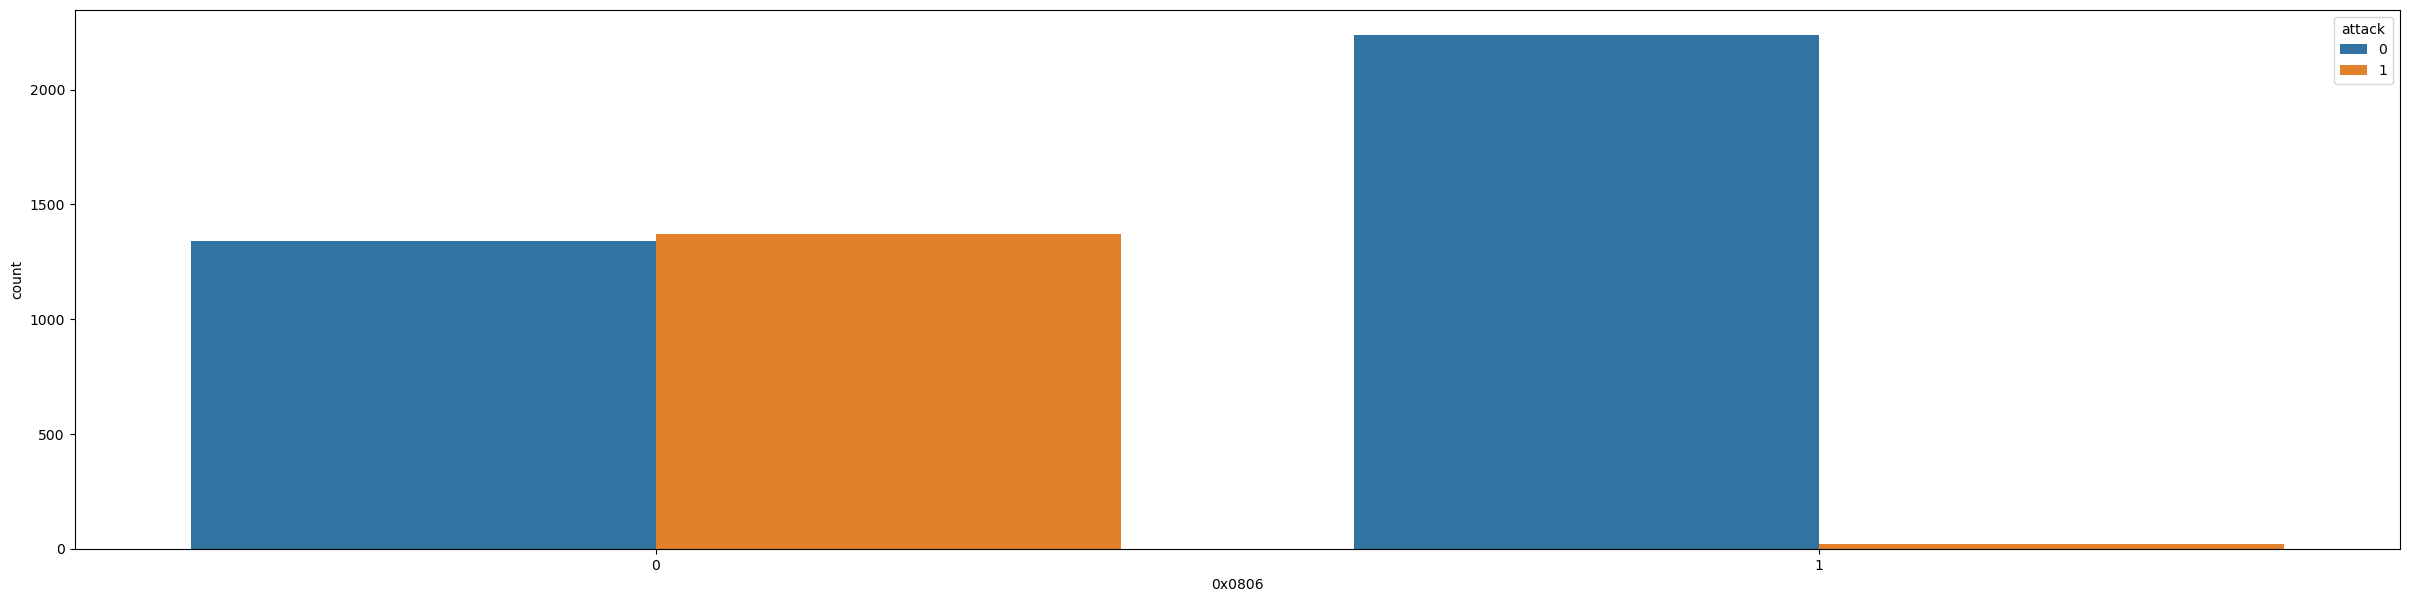

In [32]:
plt.figure(figsize=(30, 7))
sns.countplot(x='0x0806', hue='attack', data=df)
plt.show()

Packets using ARP EtherType are usually not malicious, almost all attacks employ IPv4. Despite of this fact, the model didn't assign any predictive power to this feature.